In [1]:
# Francisco Dominguez Mateos
# 17/07/2020
#https://colab.research.google.com/github/papercup-open-source/tutorials/blob/master/intro_bnn/Bayesian_neural_networks_Part_2.ipynb#scrollTo=tYA_siSEgrRl

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import jax
import jax.numpy as np
from jax import random
from jax import jit, grad
from jax import vmap, partial
import numpy as onp

from IPython.display import HTML
from matplotlib.animation import FuncAnimation

key = random.PRNGKey(0)

In [4]:
key, subkey = random.split(key)

x_range = np.linspace(-10, 10, 200)

In [5]:
def plot_fns(fns, idx, interval=250, title='Iteration'):
  x_range = np.linspace(-10, 10, 200)
  fig, ax = plt.subplots(figsize=(8, 8))
  plt.close()
  ax.set(xlim=(-10, 10), ylim=(-10, 10))

  ax.set_title("{}: 0".format(title))
  ax.scatter(D[:, 0], D[:, 1])
  line = ax.plot(x_range, fns[0], color='k', lw=2)[0]

  def animate(i):
      ax.set_title("{}: {}".format(title, idx[i]))
      line.set_ydata(fns[i])

  anim = FuncAnimation(fig, animate, interval=interval, frames=len(idx))
  return anim

Text(0, 0.5, '$y$')

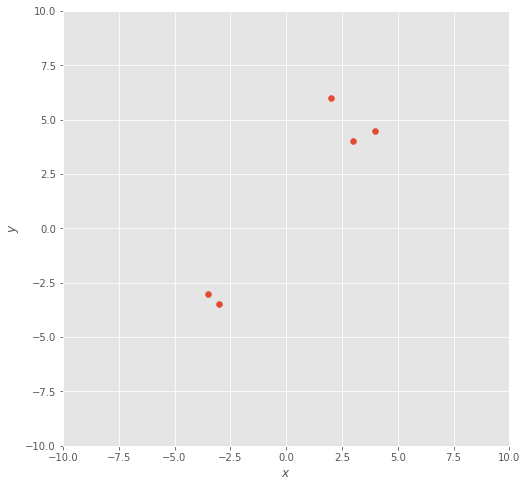

In [6]:
# Multi-layer perceptron
D = np.array([
    (-3, -3.5),
    (2, 6),
    (3, 4),
    (-3.5, -3),
    (4, 4.5),
])
x = D[:, :1]
t = D[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(D[:, 0], D[:, 1])
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [7]:
@jit
def forward_step(W, x):
  W1 = np.expand_dims(W[:N], axis=0)
  W1b = W[N:2 * N]
  W2 = W[2 * N:]

  a1 = np.dot(x, W1) + W1b
  a1 = a1 + W1b
  y1 = np.tanh(a1)
  y_in = np.concatenate((y1, np.ones((y1.shape[0], 1))), axis=1)
  y2 = np.dot(y_in, W2)

  return y2
  
@jit
def mse_loss(W, x, t):
  y2 = forward_step(W, x)

  error = 0.5 * (y2 - t) ** 2

  return error.sum()

@jit
def regularization_loss(W):
   return 0.5 * (W.dot(W)).sum()

In [8]:
eta = 0.005
N = 25
idx = []
fns = []

W = random.normal(key, (3 * N + 1,))

@jit
def step(W, D, t, eta=0.02):
  dW = grad(mse_loss)(W, x, t)
  W = W - eta * dW

  return W

for k in range(10001):
  # Calculate and save for contour lines
  if (k % 500 == 0) or (k <= 1000 and k % 100 == 0):
    idx.append(k)
    y_range = vmap(lambda i: forward_step(W, i))(x_range)
    fns.append(y_range)

  # mse_loss(W, x, t)
  W = step(W, x, t, eta=eta)

fns = np.array(fns)

In [9]:
anim = plot_fns(fns, idx, interval=100, title='Maximum Likelihood - Iteration')
HTML(anim.to_html5_video())

In [10]:
eta = 0.005
N = 25
alpha = 1
idx = []
fns = []

W = random.normal(key, (3 * N + 1,))


@jit
def regularised_loss(W, D, t, alpha):
  return mse_loss(W, D, t) + alpha * regularization_loss(W)


@jit
def step(W, D, t, eta=0.02, alpha=0.1):
  dW = grad(regularised_loss)(W, x, t, alpha)
  W = W - eta * dW

  return W

for k in range(3001):
  # Calculate and save for contour lines
  if (k % 200 == 0) or (k <= 1000 and k % 50 == 0):
    idx.append(k)
    y_range = vmap(lambda i: forward_step(W, i))(x_range)
    fns.append(y_range)

  # mse_loss(W, x, t)
  W = step(W, x, t, eta=eta, alpha=alpha)

fns = np.array(fns)

In [11]:
anim = plot_fns(fns, idx, interval=100, title='Maximum A Posteriori - Iteration')
HTML(anim.to_html5_video())

Langevin Monte Carlo method

In [12]:
eta = 0.005
epsilon = np.sqrt(2 * eta)
N = 25
alpha = 1
idx = []
fns = []

W = random.normal(key, (3 * N + 1,))

k0 = 1000

@jit
def loss(W, x, t, alpha):
  return mse_loss(W, x, t) + alpha * regularization_loss(W)


@jit
def step(W, dW, M, k1):
  p = random.normal(k1, (3 * N + 1,))
  H = (p ** 2).sum() / 2 + M
  
  # For Hamiltonian Monte Carlo, run the following 4 lines for tau iterations, 
  # tau > 1
  p = p - epsilon / 2 * dW
  new_W = W + epsilon * p
  new_dW = grad(loss)(new_W, x, t, alpha=alpha)
  p = p - epsilon / 2 * new_dW

  new_M = loss(new_W, x, t, alpha=alpha)
  new_H = (p ** 2).sum() / 2 + new_M

  dH = new_H - H

  return dH, new_W, new_dW, new_M, k1

accepts = 0
M = loss(W, x, t, alpha=alpha)
dW = grad(loss)(W, x, t, alpha=alpha)

k1, k2 = random.split(key)

for k in range(5001):
  k1, k2 = random.split(k1)
  dH, new_W, new_dW, new_M, k1 = step(W, dW, M, k1)

  if (dH < 0) or (random.uniform(k2) < np.exp(-dH)):
    accepts += 1
    W = new_W
    M = new_M
    dW = new_dW

  if (k <= k0 and k > 0 and k % 10 == 0) or (k > k0 and k % 20 == 0):
    y_range = vmap(lambda i: forward_step(W, i))(x_range)
    fns.append(y_range)
    idx.append(k)

fns = np.array(fns)

In [13]:
print(accepts)

3703


In [14]:
anim = plot_fns(fns[:100], range(len(fns[:100])), title='LMC - Sample:')
HTML(anim.to_html5_video())

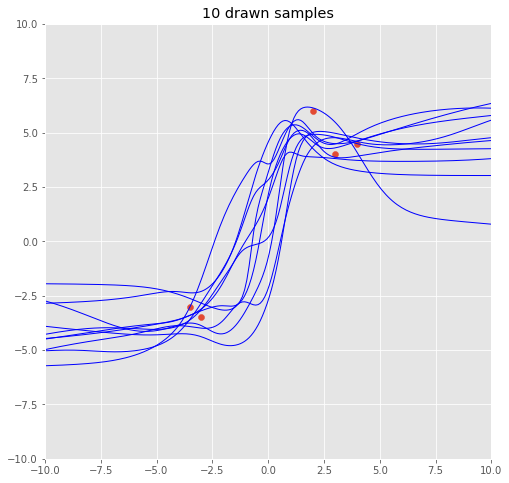

In [15]:
sampled_idx = onp.random.choice(range(fns.shape[0]), 10)
sampled_fns = fns[sampled_idx]

x_range = np.linspace(-10, 10, 200)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set(xlim=(-10, 10), ylim=(-10, 10))

ax.set_title("10 drawn samples")
ax.scatter(D[:, 0], D[:, 1])

for i, fn in enumerate(sampled_fns):
  _ = ax.plot(x_range, fn, color='b', lw=1)

Text(0, 0.5, '$y$')

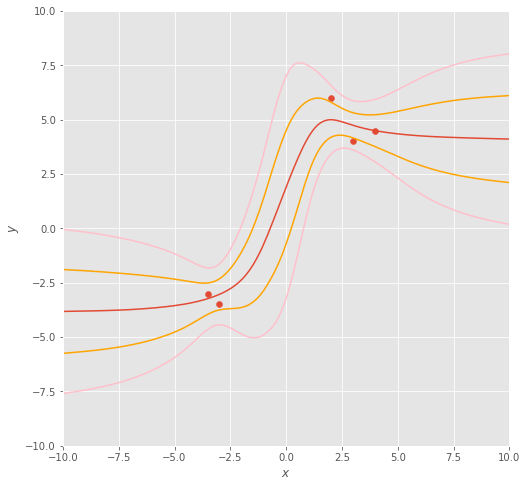

In [16]:
mean_fn = fns.mean(axis=0)
plus_fn = mean_fn + fns.std(axis=0)
minus_fn = mean_fn - fns.std(axis=0)
plus_fn_2 = mean_fn + 1.96 * fns.std(axis=0)
minus_fn_2 = mean_fn - 1.96 * fns.std(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(D[:, 0], D[:, 1])
plt.plot(x_range, mean_fn)
plt.plot(x_range, plus_fn, color='orange')
plt.plot(x_range, minus_fn, color='orange')
plt.plot(x_range, plus_fn_2, color='pink')
plt.plot(x_range, minus_fn_2, color='pink')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('$x$')
plt.ylabel('$y$')

Variational Free Energy method

In [17]:
eta = 0.005
N = 25
M = 3 * N + 1
alpha = 1
K = 10 # Number of Monte Carlo samples
idx = []
fns = []

theta = random.normal(key, (2 * M,))
k1, k2 = random.split(key)


@jit
def loss(W, x, t, alpha):
  return mse_loss(W, x, t) + alpha * regularization_loss(W)


@jit
def vi_loss(theta, eps, x, t, alpha):
  mu = theta[:M]
  log_sigma = theta[M:]
  sigma = np.exp(log_sigma)
  W = mu + eps * sigma
  errors = loss(W, x, t, alpha)

  return errors

@jit
def KL_loss(theta):
  log_sigma = theta[M:]
  return - (log_sigma).sum()

@jit
def step(theta, D, t, k1, eta=0.02, alpha=0.01):
  eps = random.normal(k1, (K, M))

  partial_loss_func = partial(lambda e: grad(vi_loss)(theta, e, x=x, t=t, alpha=alpha))

  dtheta = np.nanmean(vmap(partial_loss_func)(eps), 0)

  d_KL_theta = grad(KL_loss)(theta)

  theta = theta - eta * (dtheta + d_KL_theta)

  return theta

for k in range(5001):
  k1, k2 = random.split(k1)

  theta = step(theta, x, t, k1, eta=eta, alpha=alpha)

In [18]:
# Monte Carlo method for inference
K_inference = 30
mu = theta[:M]
log_sigma = theta[M:]
sigma = np.exp(log_sigma)

k1, k2 = random.split(key)
eps = random.normal(k1, (K_inference, M))

partial_func = partial(lambda e: np.multiply(sigma, e))
W = mu + vmap(partial_func)(eps)

fns = vmap(lambda w: vmap(lambda i: forward_step(w, i))(x_range))(W)

anim = plot_fns(fns, range(len(fns)), interval=250, title='VI - Samples')
HTML(anim.to_html5_video())

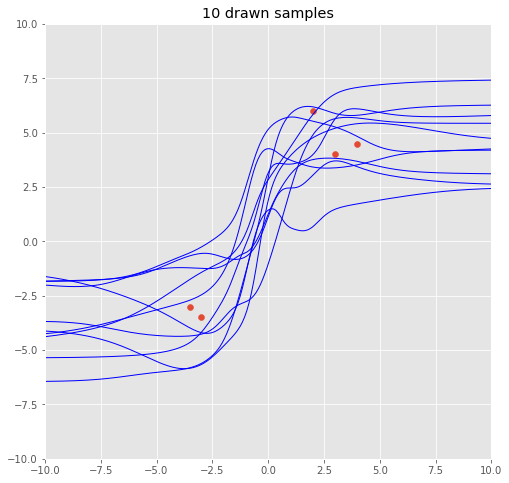

In [19]:
sampled_idx = onp.random.choice(range(fns.shape[0]), 10, replace=False)
sampled_fns = fns[sampled_idx]

x_range = np.linspace(-10, 10, 200)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set(xlim=(-10, 10), ylim=(-10, 10))

ax.set_title("10 drawn samples")
ax.scatter(D[:, 0], D[:, 1])

for i, fn in enumerate(sampled_fns):
  _ = ax.plot(x_range, fn, color='b', lw=1)

Text(0, 0.5, '$y$')

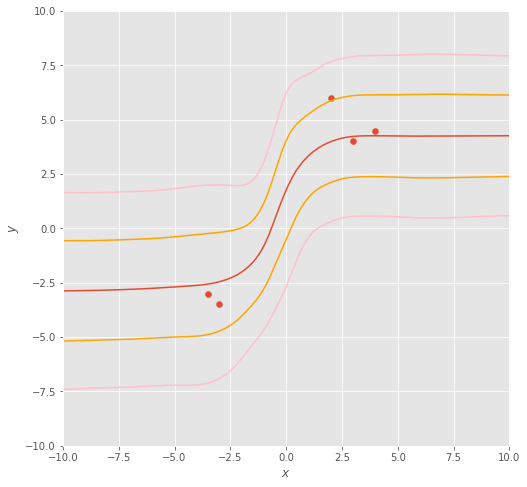

In [20]:
mean_fn = fns.mean(axis=0)
plus_fn = mean_fn + fns.std(axis=0)
minus_fn = mean_fn - fns.std(axis=0)
plus_fn_2 = mean_fn + 1.96 * fns.std(axis=0)
minus_fn_2 = mean_fn - 1.96 * fns.std(axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(D[:, 0], D[:, 1])
plt.plot(x_range, mean_fn)
plt.plot(x_range, plus_fn, color='orange')
plt.plot(x_range, minus_fn, color='orange')
plt.plot(x_range, plus_fn_2, color='pink')
plt.plot(x_range, minus_fn_2, color='pink')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('$x$')
plt.ylabel('$y$')